Shape-Based Industrial Object Recognition for Automated Sorting
Concepts Used: Chain Coding, Contour Detection, Image Thresholding, Morphological Operations
Problem Statement:
Design an industrial object recognition system that can:
• Identify objects of different shapes using contour detection and chain coding.
• Classify the objects based on their chain code shape number.
• Use morphological operations to clean noisy images before processing.
• Generate a unique feature descriptor for each object and sort them into categories.
Expected Output:
A system that can take an image of different objects and correctly classify them into predefined shape
categories using chain coding.

Lakshita Sharma 1032222435


Object Classification Summary:
Category 1 (Shape #0):
  Number of objects: 2
  Object IDs: obj_1, obj_2

Category 2 (Shape #302079):
  Number of objects: 1
  Object IDs: obj_3

Category 3 (Shape #120632137669485):
  Number of objects: 1
  Object IDs: obj_4

Category 4 (Shape #321685702049791):
  Number of objects: 1
  Object IDs: obj_5

Category 5 (Shape #84328053330115231743):
  Number of objects: 1
  Object IDs: obj_0



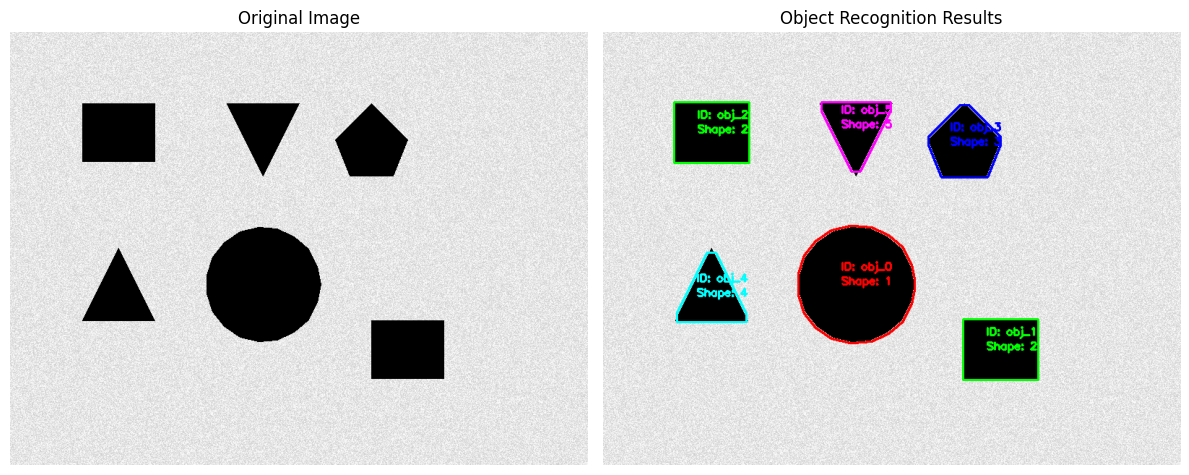


Clustering objects by shape similarity:
Cluster 3: obj_0
Cluster 1: obj_1, obj_2, obj_5
Cluster 2: obj_3, obj_4


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import defaultdict

class ShapeRecognizer:
    def __init__(self):
        self.shape_descriptors = {}
        self.chain_codes = {}
        self.categories = defaultdict(list)

    def preprocess_image(self, image):
        """
        Preprocess an image using thresholding and morphological operations
        to clean noise and prepare for contour detection.
        """
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Apply morphological operations to clean noise
        kernel = np.ones((5, 5), np.uint8)
        opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
        # Dilate to ensure complete contours
        dilated = cv2.dilate(opening, kernel, iterations=1)

        return dilated

    def extract_contours(self, preprocessed_image):
        """
        Extract contours from preprocessed image.
        Returns contours sorted by area (largest first).
        """
        contours, _ = cv2.findContours(
            preprocessed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        # Sort contours by area (largest first)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)

        return contours

    def generate_chain_code(self, contour, sampling_rate=10):
        """
        Generate 8-direction Freeman chain code for a contour.
        Samples the contour at regular intervals to reduce dimensionality.
        """
        # Resample contour at regular intervals
        contour_points = contour.reshape(-1, 2)
        sampled_points = contour_points[::sampling_rate]

        if len(sampled_points) < 2:
            return []

        chain_code = []
        for i in range(1, len(sampled_points)):
            dx = sampled_points[i][0] - sampled_points[i-1][0]
            dy = sampled_points[i][1] - sampled_points[i-1][1]

            # Determine direction (8-connectivity)
            if dx > 0 and dy == 0:
                direction = 0  # East
            elif dx > 0 and dy < 0:
                direction = 1  # North-East
            elif dx == 0 and dy < 0:
                direction = 2  # North
            elif dx < 0 and dy < 0:
                direction = 3  # North-West
            elif dx < 0 and dy == 0:
                direction = 4  # West
            elif dx < 0 and dy > 0:
                direction = 5  # South-West
            elif dx == 0 and dy > 0:
                direction = 6  # South
            else:  # dx > 0 and dy > 0
                direction = 7  # South-East

            chain_code.append(direction)

        return chain_code

    def calculate_shape_number(self, chain_code):
        """
        Calculate a shape number from the chain code.
        The shape number is rotation-invariant.
        """
        if not chain_code:
            return 0

        # Find the minimum starting point for rotation invariance
        min_code = chain_code
        for i in range(1, len(chain_code)):
            rotated_code = chain_code[i:] + chain_code[:i]
            if rotated_code < min_code:
                min_code = rotated_code

        # Convert chain code to shape number
        shape_number = 0
        for i, code in enumerate(min_code):
            shape_number += code * (8 ** (len(min_code) - i - 1))

        return shape_number

    def extract_shape_features(self, contour):
        """
        Extract comprehensive shape features from a contour.
        """
        # Calculate basic shape metrics
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)

        # Prevent division by zero
        if perimeter == 0:
            circularity = 0
        else:
            circularity = 4 * np.pi * area / (perimeter ** 2)

        # Fit an ellipse and get its properties
        if len(contour) >= 5:  # Need at least 5 points to fit an ellipse
            ellipse = cv2.fitEllipse(contour)
            major_axis = max(ellipse[1])
            minor_axis = min(ellipse[1])
            if major_axis > 0:
                eccentricity = np.sqrt(1 - (minor_axis/major_axis)**2)
                orientation = ellipse[2]
            else:
                eccentricity = 0
                orientation = 0
        else:
            eccentricity = 0
            orientation = 0

        # Calculate convex hull and convexity
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        if hull_area > 0:
            convexity = area / hull_area
        else:
            convexity = 0

        # Calculate moments and Hu moments for shape recognition
        moments = cv2.moments(contour)
        hu_moments = cv2.HuMoments(moments).flatten()

        # Log transform Hu moments for better numerical stability
        for i in range(len(hu_moments)):
            if hu_moments[i] != 0:
                hu_moments[i] = -np.sign(hu_moments[i]) * np.log10(abs(hu_moments[i]))

        # Create feature vector
        features = {
            'area': area,
            'perimeter': perimeter,
            'circularity': circularity,
            'eccentricity': eccentricity,
            'convexity': convexity,
            'orientation': orientation,
            'hu_moments': hu_moments
        }

        return features

    def analyze_object(self, contour, object_id):
        """
        Analyze a single object contour and store its descriptors.
        """
        # Generate chain code
        chain_code = self.generate_chain_code(contour)
        shape_number = self.calculate_shape_number(chain_code)

        # Extract comprehensive shape features
        features = self.extract_shape_features(contour)

        # Store results
        self.chain_codes[object_id] = chain_code
        self.shape_descriptors[object_id] = {
            'shape_number': shape_number,
            'features': features
        }

        return shape_number

    def classify_objects(self, image):
        """
        Process an image, detect objects, and classify them by shape.
        """
        # Preprocess the image
        preprocessed = self.preprocess_image(image)

        # Extract contours
        contours = self.extract_contours(preprocessed)

        # Analyze each object
        results = []
        self.categories.clear()

        for i, contour in enumerate(contours):
            # Skip very small contours (likely noise)
            if cv2.contourArea(contour) < 100:
                continue

            object_id = f"obj_{i}"
            shape_number = self.analyze_object(contour, object_id)

            # Group by shape number (objects with similar shape will have similar numbers)
            self.categories[shape_number].append(object_id)

            results.append({
                'object_id': object_id,
                'shape_number': shape_number,
                'contour': contour,
                'features': self.shape_descriptors[object_id]['features']
            })

        return results

    def cluster_objects(self, n_clusters=5):
        """
        Cluster objects based on their shape features using KMeans.
        """
        if not self.shape_descriptors:
            return {}

        # Extract features for clustering
        object_ids = list(self.shape_descriptors.keys())

        # Create feature matrix using Hu moments
        features = np.array([self.shape_descriptors[obj_id]['features']['hu_moments']
                            for obj_id in object_ids])

        # Apply KMeans clustering
        kmeans = KMeans(n_clusters=min(n_clusters, len(features)), random_state=42)
        clusters = kmeans.fit_predict(features)

        # Group objects by cluster
        clustered_objects = defaultdict(list)
        for i, cluster_id in enumerate(clusters):
            clustered_objects[cluster_id].append(object_ids[i])

        return clustered_objects

    def visualize_results(self, original_image, results):
        """
        Visualize the detected objects and their classifications.
        """
        # Create a copy of the original image for visualization
        if len(original_image.shape) == 2:
            vis_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)
        else:
            vis_image = original_image.copy()

        # Define colors for different shape categories
        colors = [
            (0, 0, 255),    # Red
            (0, 255, 0),    # Green
            (255, 0, 0),    # Blue
            (255, 255, 0),  # Cyan
            (255, 0, 255),  # Magenta
            (0, 255, 255),  # Yellow
            (128, 0, 0),    # Dark blue
            (0, 128, 0),    # Dark green
            (0, 0, 128),    # Dark red
        ]

        # Get unique shape numbers
        shape_numbers = list(self.categories.keys())

        # Draw contours with different colors for different shape categories
        for i, result in enumerate(results):
            shape_number = result['shape_number']
            shape_idx = shape_numbers.index(shape_number) % len(colors)
            color = colors[shape_idx]

            # Draw contour
            cv2.drawContours(vis_image, [result['contour']], -1, color, 2)

            # Get contour center for labeling
            M = cv2.moments(result['contour'])
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                cX, cY = 0, 0

            # Add label
            cv2.putText(vis_image, f"ID: {result['object_id']}", (cX - 20, cY - 20),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            cv2.putText(vis_image, f"Shape: {shape_idx+1}", (cX - 20, cY),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        return vis_image

    def print_category_summary(self):
        """
        Print a summary of the shape categories.
        """
        print("\nObject Classification Summary:")
        print("==============================")
        for i, (shape_number, objects) in enumerate(sorted(self.categories.items())):
            print(f"Category {i+1} (Shape #{shape_number}):")
            print(f"  Number of objects: {len(objects)}")
            print(f"  Object IDs: {', '.join(objects)}")
            print()


# Usage example
def run_example():
    # Load test image (create a synthetic one for demonstration)
    width, height = 800, 600
    image = np.ones((height, width), dtype=np.uint8) * 255

    # Draw some shapes
    shapes = [
        # Rectangles
        np.array([[100, 100], [200, 100], [200, 180], [100, 180]], dtype=np.int32),
        np.array([[500, 400], [600, 400], [600, 480], [500, 480]], dtype=np.int32),

        # Triangles
        np.array([[300, 100], [400, 100], [350, 200]], dtype=np.int32),
        np.array([[100, 400], [200, 400], [150, 300]], dtype=np.int32),

        # Pentagon
        np.array([[500, 100], [550, 150], [530, 200], [470, 200], [450, 150]], dtype=np.int32),

        # Circle-like shape (approximated by many points)
        np.array([[350 + int(80*np.cos(t)), 350 + int(80*np.sin(t))] for t in np.linspace(0, 2*np.pi, 20)], dtype=np.int32)
    ]

    # Fill the shapes
    for shape in shapes:
        cv2.fillPoly(image, [shape], 0)

    noise = np.random.randint(0, 50, size=image.shape, dtype=np.uint8)
    image = cv2.subtract(image, noise)

    recognizer = ShapeRecognizer()

    results = recognizer.classify_objects(image)

    # Print summary
    recognizer.print_category_summary()

    vis_image = recognizer.visualize_results(image, results)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
    plt.title('Object Recognition Results')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Cluster objects based on shape features
    print("\nClustering objects by shape similarity:")
    clustered_objects = recognizer.cluster_objects(n_clusters=3)
    for cluster_id, objects in clustered_objects.items():
        print(f"Cluster {cluster_id+1}: {', '.join(objects)}")


if __name__ == "__main__":
    run_example()

Initializing Fastener Recognition System...
Creating synthetic training data...
Training fastener classifier...
Training completed.
Creating test image...
Processing test image...

Fastener Detection Summary:
Detected fasteners:
  Washer: 1
  Nut: 1
  Rivet: 1
  Screw: 1
  Bolt: 1

Total fasteners: 5


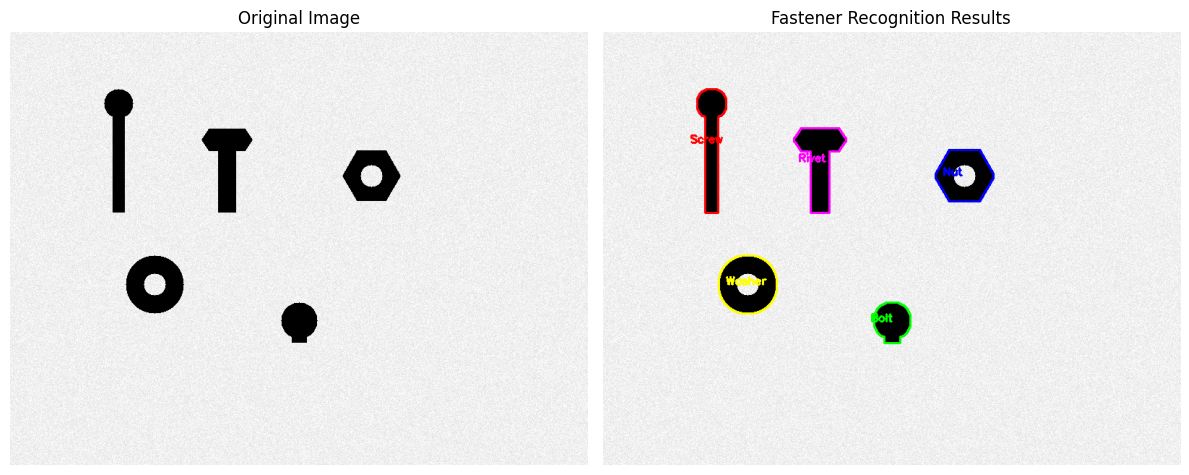

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import defaultdict
import os

class FastenerRecognizer:
    def __init__(self):
        self.shape_descriptors = {}
        self.chain_codes = {}
        self.categories = defaultdict(list)
        self.fastener_types = {
            0: "Unknown",
            1: "Screw",
            2: "Bolt",
            3: "Nut",
            4: "Washer",
            5: "Rivet"
        }
        # Store trained classifier info
        self.is_trained = False
        self.centroids = None
        self.feature_means = None

    def preprocess_image(self, image):
        """
        Preprocess an image using thresholding and morphological operations
        to clean noise and prepare for contour detection.
        """
        # Convert to grayscale if not already
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Apply adaptive thresholding for better handling of lighting variations
        binary = cv2.adaptiveThreshold(
            blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV, 11, 2
        )

        # Apply morphological operations to clean noise
        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

        # Dilate to ensure complete contours
        dilated = cv2.dilate(opening, kernel, iterations=1)

        return dilated

    def extract_contours(self, preprocessed_image):
        """
        Extract contours from preprocessed image.
        Returns contours sorted by area (largest first).
        """
        contours, _ = cv2.findContours(
            preprocessed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        # Filter out very small contours (likely noise)
        filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]

        # Sort contours by area (largest first)
        filtered_contours = sorted(filtered_contours, key=cv2.contourArea, reverse=True)

        return filtered_contours

    def generate_chain_code(self, contour, sampling_rate=10):
        """
        Generate 8-direction Freeman chain code for a contour.
        Samples the contour at regular intervals to reduce dimensionality.
        """
        # Resample contour at regular intervals
        contour_points = contour.reshape(-1, 2)

        # Adjust sampling rate based on contour size
        sample_count = max(20, len(contour_points) // sampling_rate)
        indices = np.linspace(0, len(contour_points) - 1, sample_count, dtype=int)
        sampled_points = contour_points[indices]

        if len(sampled_points) < 2:
            return []

        chain_code = []
        for i in range(1, len(sampled_points)):
            dx = sampled_points[i][0] - sampled_points[i-1][0]
            dy = sampled_points[i][1] - sampled_points[i-1][1]

            # Determine direction (8-connectivity)
            if dx > 0 and dy == 0:
                direction = 0  # East
            elif dx > 0 and dy < 0:
                direction = 1  # North-East
            elif dx == 0 and dy < 0:
                direction = 2  # North
            elif dx < 0 and dy < 0:
                direction = 3  # North-West
            elif dx < 0 and dy == 0:
                direction = 4  # West
            elif dx < 0 and dy > 0:
                direction = 5  # South-West
            elif dx == 0 and dy > 0:
                direction = 6  # South
            else:  # dx > 0 and dy > 0
                direction = 7  # South-East

            chain_code.append(direction)

        return chain_code

    def extract_fastener_features(self, contour, image=None):
        """
        Extract features specifically relevant for fastener classification.
        """
        # Basic shape metrics
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)

        # Prevent division by zero
        if perimeter == 0:
            circularity = 0
        else:
            circularity = 4 * np.pi * area / (perimeter ** 2)

        # Calculate bounding rectangle and minimum enclosing circle
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h if h > 0 else 0

        (center_x, center_y), radius = cv2.minEnclosingCircle(contour)
        enclosing_circle_area = np.pi * radius * radius

        # Calculate circle fill ratio (how much of the enclosing circle is filled)
        if enclosing_circle_area > 0:
            circle_fill_ratio = area / enclosing_circle_area
        else:
            circle_fill_ratio = 0

        # Calculate rectangle fill ratio
        rect_area = w * h
        if rect_area > 0:
            rect_fill_ratio = area / rect_area
        else:
            rect_fill_ratio = 0

        # Fit an ellipse if possible
        if len(contour) >= 5:  # Need at least 5 points to fit an ellipse
            try:
                ellipse = cv2.fitEllipse(contour)
                major_axis = max(ellipse[1])
                minor_axis = min(ellipse[1])
                if major_axis > 0:
                    eccentricity = np.sqrt(1 - (minor_axis/major_axis)**2)
                else:
                    eccentricity = 0
            except:
                eccentricity = 0
        else:
            eccentricity = 0

        # Calculate convex hull and convexity
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        if hull_area > 0:
            convexity = area / hull_area
        else:
            convexity = 0

        # Calculate the number of holes (important for nuts, washers)
        if image is not None:
            mask = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.drawContours(mask, [contour], 0, 255, -1)

            # Count internal contours (holes)
            internal_contours, _ = cv2.findContours(
                mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
            hole_count = max(0, len(internal_contours) - 1)
        else:
            hole_count = 0

        # Calculate moments and Hu moments for shape recognition
        moments = cv2.moments(contour)
        hu_moments = cv2.HuMoments(moments).flatten()

        # Log transform Hu moments for better numerical stability
        for i in range(len(hu_moments)):
            if hu_moments[i] != 0:
                hu_moments[i] = -np.sign(hu_moments[i]) * np.log10(abs(hu_moments[i]))

        # Check for approx polygon shape (useful for hex nuts, hex heads)
        epsilon = 0.03 * perimeter
        approx = cv2.approxPolyDP(contour, epsilon, True)
        vertex_count = len(approx)

        # Create feature vector - these are particularly useful for fastener classification
        features = {
            'area': area,
            'perimeter': perimeter,
            'circularity': circularity,
            'aspect_ratio': aspect_ratio,
            'rect_fill_ratio': rect_fill_ratio,
            'circle_fill_ratio': circle_fill_ratio,
            'eccentricity': eccentricity,
            'convexity': convexity,
            'hole_count': hole_count,
            'vertex_count': vertex_count,
            'hu_moments': hu_moments
        }

        # Create a feature vector specifically for classification
        feature_vector = np.array([
            circularity,
            aspect_ratio,
            rect_fill_ratio,
            circle_fill_ratio,
            eccentricity,
            convexity,
            hole_count,
            vertex_count
        ])

        features['feature_vector'] = feature_vector

        return features

    def train_fastener_classifier(self, training_data):
        """
        Train a classifier using labeled fastener data.
        training_data: list of (image_path, label) tuples
        """
        print("Training fastener classifier...")
        features_list = []
        labels = []

        for image_path, label in training_data:
            # Load and process image
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Could not load {image_path}")
                continue

            preprocessed = self.preprocess_image(image)
            contours = self.extract_contours(preprocessed)

            if not contours:
                print(f"Warning: No contours found in {image_path}")
                continue

            # Use the largest contour
            features = self.extract_fastener_features(contours[0], preprocessed)
            features_list.append(features['feature_vector'])
            labels.append(label)

        if len(features_list) < 2:
            print("Not enough training samples!")
            return False

        # Convert to numpy arrays
        X = np.array(features_list)
        y = np.array(labels)

        # Store feature means for each class
        self.feature_means = {}
        for label in np.unique(y):
            class_features = X[y == label]
            self.feature_means[label] = np.mean(class_features, axis=0)

        # Train KMeans model with class count
        n_clusters = len(np.unique(y))
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X)

        # Store centroids
        self.centroids = kmeans.cluster_centers_
        self.is_trained = True
        print("Training completed.")

        return True

    def classify_fastener(self, features):
        """
        Classify a fastener based on its features.
        """
        if not self.is_trained:
            # Fallback classification based on heuristics if not trained
            return self._heuristic_classification(features)

        # Get feature vector
        feature_vector = features['feature_vector']

        # Find nearest centroid/class
        min_dist = float('inf')
        best_class = 0

        for label, mean_features in self.feature_means.items():
            dist = np.linalg.norm(feature_vector - mean_features)
            if dist < min_dist:
                min_dist = dist
                best_class = label

        return best_class

    def _heuristic_classification(self, features):
        """
        Use simple heuristics to classify fasteners when no trained model is available.
        """
        # Extract key features
        circularity = features['circularity']
        aspect_ratio = features['aspect_ratio']
        rect_fill = features['rect_fill_ratio']
        circle_fill = features['circle_fill_ratio']
        hole_count = features['hole_count']
        vertex_count = features['vertex_count']

        # Washer detection (highly circular with hole)
        if circularity > 0.8 and circle_fill > 0.4 and circle_fill < 0.9 and hole_count > 0:
            return 4  # Washer

        # Nut detection (hexagonal with hole)
        if vertex_count >= 5 and vertex_count <= 8 and hole_count > 0:
            return 3  # Nut

        # Screw detection (elongated with head)
        if aspect_ratio > 2.5:
            return 1  # Screw

        # Bolt detection (elongated, less than screw usually)
        if aspect_ratio > 1.5 and aspect_ratio <= 2.5:
            return 2  # Bolt

        # Rivet detection (smaller, circular head)
        if circularity > 0.7 and aspect_ratio < 1.5:
            return 5  # Rivet

        # Default
        return 0  # Unknown

    def process_image(self, image_path):
        """
        Process an image to detect and classify fasteners.
        """
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not load image {image_path}")
            return None, None

        # Preprocess the image
        preprocessed = self.preprocess_image(image)

        # Extract contours
        contours = self.extract_contours(preprocessed)

        # Process each fastener
        results = []
        self.categories.clear()

        for i, contour in enumerate(contours):
            # Skip very small contours
            if cv2.contourArea(contour) < 150:
                continue

            # Generate object ID
            object_id = f"fastener_{i}"

            # Extract chain code
            chain_code = self.generate_chain_code(contour)
            self.chain_codes[object_id] = chain_code

            # Extract features
            features = self.extract_fastener_features(contour, preprocessed)
            self.shape_descriptors[object_id] = features

            # Classify fastener
            fastener_type = self.classify_fastener(features)
            fastener_name = self.fastener_types.get(fastener_type, "Unknown")

            # Store result
            result = {
                'object_id': object_id,
                'contour': contour,
                'fastener_type': fastener_type,
                'fastener_name': fastener_name,
                'features': features
            }
            results.append(result)

            # Group by fastener type
            self.categories[fastener_type].append(object_id)

        return image, results

    def visualize_results(self, image, results):
        """
        Visualize the detected fasteners and their classifications.
        """
        # Create a copy of the image for visualization
        vis_image = image.copy()

        # Define colors for different fastener types
        colors = {
            0: (200, 200, 200),  # Unknown - Gray
            1: (0, 0, 255),      # Screw - Red
            2: (0, 255, 0),      # Bolt - Green
            3: (255, 0, 0),      # Nut - Blue
            4: (0, 255, 255),    # Washer - Yellow
            5: (255, 0, 255)     # Rivet - Magenta
        }

        # Draw contours and labels
        for result in results:
            fastener_type = result['fastener_type']
            color = colors.get(fastener_type, colors[0])

            # Draw contour
            cv2.drawContours(vis_image, [result['contour']], -1, color, 2)

            # Calculate centroid
            M = cv2.moments(result['contour'])
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                # Fallback to bounding rect center
                x, y, w, h = cv2.boundingRect(result['contour'])
                cX, cY = x + w//2, y + h//2

            # Add label
            label = result['fastener_name']
            cv2.putText(vis_image, label, (cX - 30, cY),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        return vis_image

    def print_results_summary(self, results):
        """
        Print a summary of the detected fasteners.
        """
        if not results:
            print("No fasteners detected.")
            return

        print("\nFastener Detection Summary:")
        print("===========================")

        # Count by type
        type_counts = defaultdict(int)
        for result in results:
            type_counts[result['fastener_name']] += 1

        # Print counts
        print("Detected fasteners:")
        for fastener_type, count in type_counts.items():
            print(f"  {fastener_type}: {count}")

        print(f"\nTotal fasteners: {len(results)}")
        print("===========================")


def create_training_examples():
    """
    Function to create synthetic training examples for testing.
    In a real application, you would use real labeled images.
    """
    # Create directory for training images
    os.makedirs("training_data", exist_ok=True)

    # Dictionary to store training data
    training_data = []

    # Create synthetic images
    width, height = 400, 400

    # 1. Screws (elongated with head)
    for i in range(3):
        image = np.ones((height, width), dtype=np.uint8) * 255
        # Draw screw shaft
        x, y = 150, 100
        shaft_length = 200
        head_radius = 25
        cv2.rectangle(image, (x-10, y), (x+10, y+shaft_length), 0, -1)
        # Draw screw head
        cv2.circle(image, (x, y), head_radius, 0, -1)

        # Add rotation
        M = cv2.getRotationMatrix2D((width//2, height//2), 45*i, 1)
        image = cv2.warpAffine(image, M, (width, height))

        # Save image
        image_path = f"training_data/screw_{i}.jpg"
        cv2.imwrite(image_path, image)
        training_data.append((image_path, 1))  # 1 = Screw

    # 2. Bolts (shorter shaft, hex head)
    for i in range(3):
        image = np.ones((height, width), dtype=np.uint8) * 255
        # Draw bolt shaft
        x, y = 200, 150
        shaft_length = 120
        cv2.rectangle(image, (x-15, y), (x+15, y+shaft_length), 0, -1)

        # Draw hex head
        hex_head = np.array([
            [x-30, y-20], [x+30, y-20], [x+40, y],
            [x+30, y+20], [x-30, y+20], [x-40, y]
        ], dtype=np.int32)
        cv2.fillPoly(image, [hex_head], 0)

        # Add rotation
        M = cv2.getRotationMatrix2D((width//2, height//2), 60*i, 1)
        image = cv2.warpAffine(image, M, (width, height))

        # Save image
        image_path = f"training_data/bolt_{i}.jpg"
        cv2.imwrite(image_path, image)
        training_data.append((image_path, 2))  # 2 = Bolt

    # 3. Nuts (hex with hole)
    for i in range(3):
        image = np.ones((height, width), dtype=np.uint8) * 255
        # Center point
        x, y = 200, 200
        # Draw hex nut
        outer_radius = 60
        inner_radius = 20

        # Create outer polygon
        hex_points = []
        for j in range(6):
            angle = 2 * np.pi * j / 6
            px = int(x + outer_radius * np.cos(angle))
            py = int(y + outer_radius * np.sin(angle))
            hex_points.append([px, py])

        hex_nut = np.array(hex_points, dtype=np.int32)
        cv2.fillPoly(image, [hex_nut], 0)

        # Create inner hole
        cv2.circle(image, (x, y), inner_radius, 255, -1)

        # Add rotation
        M = cv2.getRotationMatrix2D((width//2, height//2), 30*i, 1)
        image = cv2.warpAffine(image, M, (width, height))

        # Save image
        image_path = f"training_data/nut_{i}.jpg"
        cv2.imwrite(image_path, image)
        training_data.append((image_path, 3))  # 3 = Nut

    # 4. Washers (circular with hole)
    for i in range(3):
        image = np.ones((height, width), dtype=np.uint8) * 255
        # Center point
        x, y = 200, 200
        # Draw washer
        outer_radius = 50 + i*5
        inner_radius = 20

        cv2.circle(image, (x, y), outer_radius, 0, -1)
        cv2.circle(image, (x, y), inner_radius, 255, -1)

        # Save image
        image_path = f"training_data/washer_{i}.jpg"
        cv2.imwrite(image_path, image)
        training_data.append((image_path, 4))  # 4 = Washer

    # 5. Rivets (small, round head with short shaft)
    for i in range(3):
        image = np.ones((height, width), dtype=np.uint8) * 255
        # Draw rivet
        x, y = 200, 180
        head_radius = 30
        shaft_length = 40
        shaft_width = 15

        # Draw rivet head
        cv2.circle(image, (x, y), head_radius, 0, -1)
        # Draw rivet shaft
        cv2.rectangle(image, (x-shaft_width//2, y), (x+shaft_width//2, y+shaft_length), 0, -1)

        # Add rotation
        M = cv2.getRotationMatrix2D((width//2, height//2), 45*i, 1)
        image = cv2.warpAffine(image, M, (width, height))

        # Save image
        image_path = f"training_data/rivet_{i}.jpg"
        cv2.imwrite(image_path, image)
        training_data.append((image_path, 5))  # 5 = Rivet

    return training_data


def create_test_image():
    """
    Create a test image with multiple fasteners.
    """
    # Create a large image
    width, height = 800, 600
    image = np.ones((height, width), dtype=np.uint8) * 255

    # Add some fasteners

    # 1. Screw
    x, y = 150, 100
    cv2.rectangle(image, (x-8, y), (x+8, y+150), 0, -1)
    cv2.circle(image, (x, y), 20, 0, -1)

    # 2. Bolt with hex head
    x, y = 300, 150
    cv2.rectangle(image, (x-12, y), (x+12, y+100), 0, -1)
    hex_head = np.array([
        [x-25, y-15], [x+25, y-15], [x+35, y],
        [x+25, y+15], [x-25, y+15], [x-35, y]
    ], dtype=np.int32)
    cv2.fillPoly(image, [hex_head], 0)

    # 3. Hex nut
    x, y = 500, 200
    hex_points = []
    for i in range(6):
        angle = 2 * np.pi * i / 6
        px = int(x + 40 * np.cos(angle))
        py = int(y + 40 * np.sin(angle))
        hex_points.append([px, py])
    hex_nut = np.array(hex_points, dtype=np.int32)
    cv2.fillPoly(image, [hex_nut], 0)
    cv2.circle(image, (x, y), 15, 255, -1)

    # 4. Washer
    x, y = 200, 350
    cv2.circle(image, (x, y), 40, 0, -1)
    cv2.circle(image, (x, y), 15, 255, -1)

    # 5. Rivet
    x, y = 400, 400
    cv2.circle(image, (x, y), 25, 0, -1)
    cv2.rectangle(image, (x-10, y), (x+10, y+30), 0, -1)

    # Add some noise
    noise = np.random.randint(0, 30, size=image.shape, dtype=np.uint8)
    image = cv2.subtract(image, noise)

    # Save the test image
    test_image_path = "fastener_test.jpg"
    cv2.imwrite(test_image_path, image)

    return test_image_path


def process_directory(recognizer, directory_path):
    """
    Process all images in a directory.
    """
    results_by_file = {}

    for filename in os.listdir(directory_path):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            image_path = os.path.join(directory_path, filename)
            print(f"Processing {filename}...")

            image, results = recognizer.process_image(image_path)
            if image is None:
                continue

            # Visualize and save results
            vis_image = recognizer.visualize_results(image, results)
            output_path = os.path.join(directory_path, f"result_{filename}")
            cv2.imwrite(output_path, vis_image)

            # Print summary
            print(f"Results for {filename}:")
            recognizer.print_results_summary(results)

            results_by_file[filename] = results

    return results_by_file


def main():
    """
    Main function demonstrating the fastener recognition system.
    """
    print("Initializing Fastener Recognition System...")
    recognizer = FastenerRecognizer()

    # Option 1: Create and use synthetic training data
    print("Creating synthetic training data...")
    training_data = create_training_examples()

    # Train the classifier
    recognizer.train_fastener_classifier(training_data)

    # Option 2: Create a synthetic test image with multiple fasteners
    print("Creating test image...")
    test_image_path = create_test_image()

    # Process the test image
    print("Processing test image...")
    image, results = recognizer.process_image(test_image_path)

    if image is not None:
        # Print results
        recognizer.print_results_summary(results)

        # Visualize results
        vis_image = recognizer.visualize_results(image, results)

        # Display results
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
        plt.title('Fastener Recognition Results')
        plt.axis('off')

        plt.tight_layout()
        plt.savefig("fastener_recognition_results.jpg")
        plt.show()

if __name__ == "__main__":
    main()

Results saved to fastener_detection_result.jpg


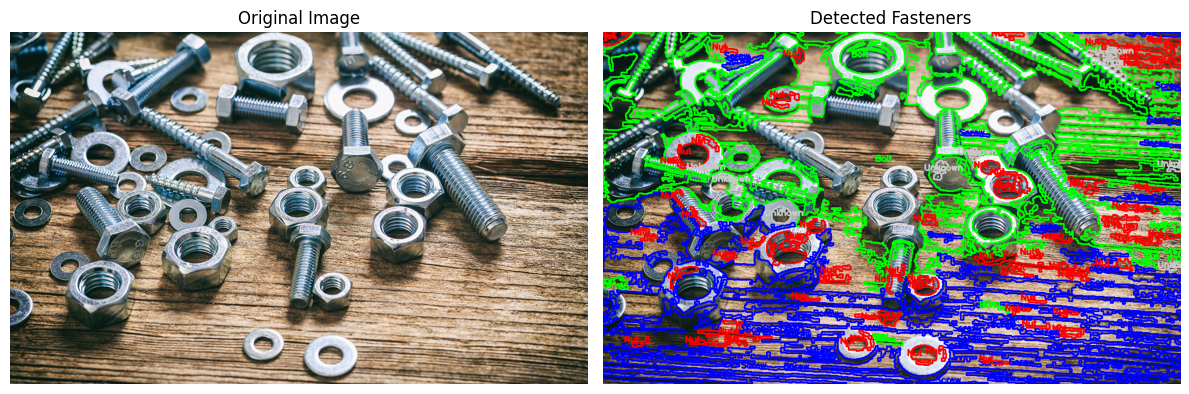

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def detect_fasteners_in_image(image_path):
    fastener_types = {
        0: "Unknown",
        1: "Screw",
        2: "Bolt",
        3: "Nut",
        4: "Washer",
        5: "Rivet"
    }

    colors = {
        0: (200, 200, 200),  # Unknown - Gray
        1: (255, 0, 0),      # Screw - Blue
        2: (0, 255, 0),      # Bolt - Green
        3: (0, 0, 255),      # Nut - Red
        4: (255, 255, 0),    # Washer - Cyan
        5: (255, 0, 255)     # Rivet - Magenta
    }

    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        return None, None

    vis_image = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    kernel = np.ones((3, 3), np.uint8)
    preprocessed = cv2.dilate(cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1), kernel, iterations=1)

    contours, _ = cv2.findContours(preprocessed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    results = []
    for i, contour in enumerate(contours):
        if cv2.contourArea(contour) < 150:
            continue

        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h if h > 0 else 0
        circularity = (4 * np.pi * cv2.contourArea(contour) / (cv2.arcLength(contour, True) ** 2)) if cv2.arcLength(contour, True) > 0 else 0

        if len(contour) >= 5:
            try:
                ellipse = cv2.fitEllipse(contour)
                major_axis, minor_axis = max(ellipse[1]), min(ellipse[1])
                eccentricity = np.sqrt(1 - (minor_axis/major_axis)**2) if major_axis > 0 else 0
            except:
                eccentricity = 0
        else:
            eccentricity = 0

        epsilon = 0.03 * cv2.arcLength(contour, True)
        vertex_count = len(cv2.approxPolyDP(contour, epsilon, True))

        fastener_type = 0
        if circularity > 0.8 and vertex_count > 5:
            fastener_type = 4  # Washer
        elif vertex_count >= 5 and vertex_count <= 8:
            fastener_type = 3  # Nut
        elif aspect_ratio > 2.5:
            fastener_type = 1  # Screw
        elif aspect_ratio > 1.5:
            fastener_type = 2  # Bolt
        elif circularity > 0.7 and aspect_ratio < 1.5:
            fastener_type = 5  # Rivet

        fastener_name = fastener_types.get(fastener_type, "Unknown")
        color = colors[fastener_type]

        cv2.drawContours(vis_image, [contour], -1, color, 2)
        cX, cY = x + w//2, y + h//2
        cv2.putText(vis_image, fastener_name, (cX - 30, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        results.append({'fastener_type': fastener_name})

    return image, vis_image, results

def display_results(original, result_img, save_path=None):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title('Detected Fasteners')
    plt.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Results saved to {save_path}")
    plt.show()

if __name__ == "__main__":
    image_path = "types-of-fasteners-step-4.jpg"
    original_img, result_img, fasteners = detect_fasteners_in_image(image_path)
    if original_img is not None:
        display_results(original_img, result_img, "fastener_detection_result.jpg")



Fastener Detection Summary:
Detected fasteners:
  Bolt: 32
  Screw: 78
  Rivet: 31
  Unknown: 1

Total fasteners: 142

Results saved to fastener_detection_result.jpg


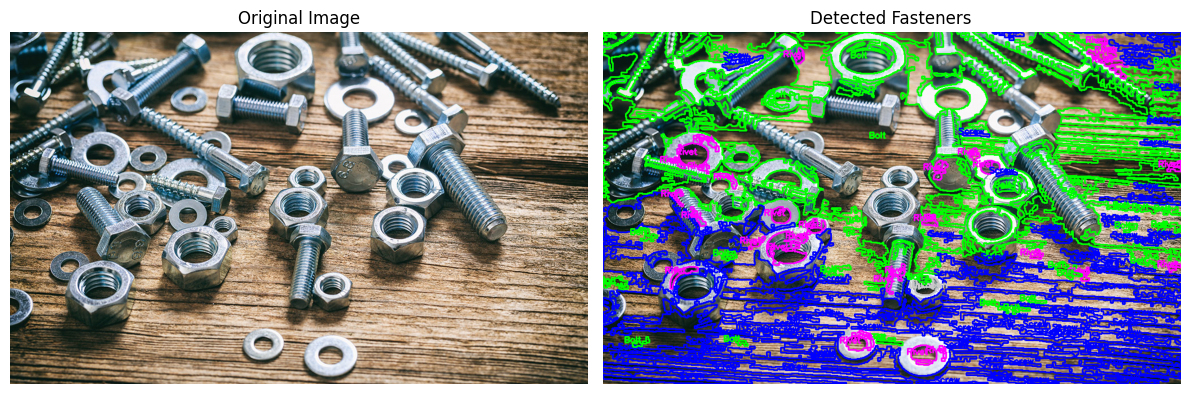


Fastener Detection Summary:
Detected fasteners:
  Bolt: 32
  Screw: 78
  Rivet: 31
  Unknown: 1

Total fasteners: 142



In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def detect_fasteners_in_image(image_path):
    """
    Detect and classify fasteners in a single image.

    Args:
        image_path (str): Path to the image file

    Returns:
        tuple: (original image, visualization image with annotations, summary text)
    """
    # Initialize fastener types dictionary
    fastener_types = {
        0: "Unknown",
        1: "Screw",
        2: "Bolt",
        3: "Nut",
        4: "Washer",
        5: "Rivet"
    }

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        return None, None, ""

    # Create a copy for visualization
    vis_image = image.copy()

    # Preprocess the image
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply adaptive thresholding for better handling of lighting variations
    binary = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2
    )
    # Apply morphological operations to clean noise
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
    # Dilate to ensure complete contours
    preprocessed = cv2.dilate(opening, kernel, iterations=1)

    # Extract contours
    contours, _ = cv2.findContours(
        preprocessed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Filter out very small contours (likely noise)
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]

    # Sort contours by area (largest first)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Process each fastener
    results = []

    # Define colors for different fastener types
    colors = {
        0: (200, 200, 200),  # Unknown - Gray
        1: (255, 0, 0),      # Screw - Blue
        2: (0, 255, 0),      # Bolt - Green
        3: (0, 0, 255),      # Nut - Red
        4: (255, 255, 0),    # Washer - Cyan
        5: (255, 0, 255)     # Rivet - Magenta
    }

    type_counts = defaultdict(int)

    for i, contour in enumerate(contours):
        if cv2.contourArea(contour) < 150:
            continue

        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h if h > 0 else 0

        fastener_type = 0  # Default: Unknown
        if aspect_ratio > 2.5:
            fastener_type = 1  # Screw
        elif aspect_ratio > 1.5 and aspect_ratio <= 2.5:
            fastener_type = 2  # Bolt
        elif aspect_ratio < 1.5:
            fastener_type = 5  # Rivet

        fastener_name = fastener_types.get(fastener_type, "Unknown")
        type_counts[fastener_name] += 1

        color = colors.get(fastener_type, colors[0])
        cv2.drawContours(vis_image, [contour], -1, color, 2)

        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = x + w//2, y + h//2

        cv2.putText(vis_image, fastener_name, (cX - 30, cY),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    summary_text = "\nFastener Detection Summary:\n===========================\n"
    summary_text += "Detected fasteners:\n"
    for fastener_type, count in type_counts.items():
        summary_text += f"  {fastener_type}: {count}\n"
    summary_text += f"\nTotal fasteners: {sum(type_counts.values())}\n===========================\n"

    print(summary_text)
    return image, vis_image, summary_text

def display_results(original, result_img, summary, save_path=None):
    """Display and optionally save the results"""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title('Detected Fasteners')
    plt.axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Results saved to {save_path}")

    plt.show()
    print(summary)

# Main execution
if __name__ == "__main__":
    image_path = "/content/types-of-fasteners-step-4.jpg"
    original_img, result_img, summary = detect_fasteners_in_image(image_path)

    if original_img is not None:
        display_results(original_img, result_img, summary, "fastener_detection_result.jpg")
